# Creating pyHS2MF6 Coupled Model Mapping Inputs

This notebook uses the test model to demonstrate how to create the **three pickle files used to map HSPF structures onto MODFLOW 6 Cells**.  To do so, it uses shapefiles that provide a description of the coupled model including GW model, 2D cell Id by cell polygon, buffered RCHRES areas, and PERLND areas. The HSPF regions (RCHRES and PERLND) are intersected with 2D model grid to provide model cell areas in each defined RCHRES and PERLND.

The three mapping dictionaries are:

1. RCHRES: buffered RCHRES areas are mapped on to or interesected with the GW model, 2D grid. Areas of each model cell within the buffered RCHRES areas are calculated. This dictionary has TargID as key with a list, RL, of values.
    - RL[0]: (int) number of exit that goes to GW
    - RL[1]: (float) total area for buffered RCHRES segment
    - RL[2]: (pd.DataFrame) 
        - index is 2D, Cell ID, 1-based
        - 4 columns
            - "iuzno" which is the cell id for the uzf package, 1-based
            - "TopActive" which is the top active layer, 1-based
            - "SArea_m2" which holds the area of the cell for the Cell ID within the buffered RCHRES segment
            - "Weight" which holds the weight factor for that cell. Needs to be >0 and <= 100.0
2. PERLND: pervious land areas are mapped on to or intersected with the GW model, 2D grid. Areas of each model cell within the specified PERLND area are calculated. This dictionary has TargID as key with a list, PL, of values.
    - PL[0]: (float) total area for PERLND region
    - PL[1]: (pd.DataFrame)
        - index is 2D, Cell ID, 1-based
        - 4 columns
            - "iuzno" which is the cell id for the uzf package, 1-based
            - "TopActive" which is the top active layer, 1-based
            - "SArea_m2" which holds the area of the cell for the Cell ID within the PERLND area
            - "Weight" which holds the weight factor for that cell. Needs to be >0 and <= 100.0
3.  Springs: springs which are represented with drain cells in the MODFLOW model are identified in this dictionary. The key is the TargID. Values are a list with a sublist for each drain cell, SL.
    - SL[0]: boundary name
    - SL[1]: NCPL, cell ID, 1-based
    - SL[2]: "TopActive" top active layer (this is the remainder of the cell id), 1-based
    - SL[3]: "SArea_m2" which holds the area of the cell for the Cell ID within the PERLND area

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon
import pickle

In [3]:
import flopy

flopy is installed in C:\Users\psouthard\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


### Identify Paths to Models and Shapefiles

The user of this notebook can perform the same operations on their own model and HSPF shapefiles by swapping out pathnames in this section.

In [4]:
# Find ROOT directory
ROOT = os.path.dirname(os.getcwd())
print(ROOT)

C:\Users\psouthard\Documents\R6015_Local2WayCoupling\pyHS2MF6\example_models


In [5]:
# Provide path to Test model Modflow 6 directory
MF6_Dir = os.path.join(ROOT,r'coupled/MF6')
# Name of Modflow 6 Model
MF6_Root = r"DC_MF6"

In [6]:
# Directory to save out files
OUT_DIR = os.path.join(ROOT,r'coupled')

Below, we point to shapefiles we created in ArcGIS or elsewhere to assist in the creation of this mapping file.  When creating your own, you have some leeway.  For example, we buffered stream reach line segments by 100m to create polygons where water can be passed from RCHRES reservoirs in HSPF to MODFLOW model cells, but a user could define their own buffer or even manually delineate the extent of surface water-groundwater interaction for the mapping.

In [7]:
# Locations of shapefiles used in HSPF model creation
# Buffered Reaches Shapefile
Reach_shp = os.path.join(ROOT,r'gis_files\Buffered_Reaches_100m.shp')
# HRU's Shapefile
Sub_shp = os.path.join(ROOT,r'gis_files\HRUs.shp')
# Watershed Shapefile
WS_shp = os.path.join(ROOT,r'gis_files\DC_Watershed_SmPAEK100m_Simp50m.shp')
# Modflow Grid Shapefile
MGrid_shp = os.path.join(ROOT,r'gis_files\cpMGridUzfNo.shp')

**Assume**: The stream reaches are represented by buffered polygons that are clipped so that are non-overlapping. In addition, the model grid shapefile contains the iuzno and CellID and top active layer for every 2D cell, as well as information for applying weights, if desired.

## Creating a Modflow Grid Shapefile with FloPy

A shapefile for the Modflow grid with attached information regarding the top active layer, Modflow Cell ID #, UZF Cell ID # and our weighting is referenced above and is what we will use in creating our mapping files.  **This section provides some code that a user can use to make a shapefile of their own MODFLOW grid using flopy.**  The idea here is that the user could create the grid and then use some other GIS software to append information to the shapefile that will go into whatever calculation they use to determine weights.

### Loading a MODFLOW 6 model

In this section we load a MODFLOW 6 file using flopy software, a python package for creating and modifying modflow input files and processing modflow outputs.

In [8]:
# Create the simulation object
mf6_sim = flopy.mf6.MFSimulation.load( MF6_Root, 'mf6', 'mf6', MF6_Dir )

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package uzf...
    loading package ic...
    loading package gnc...
    loading package sto...
    loading package npf...
    loading package ghb...
    loading package chd...
    loading package drn...
    loading package oc...
    loading package riv...
    loading package rch...
  loading ims package dc_mf6...


In [9]:
# Get Model obejct for model in simulation
mf6 = mf6_sim.get_model( MF6_Root.lower() )

### Create GeoPandas GeoDataFrame of model grid

This section defines and then uses a function to create a 2D GeoPandas GeoDataFrame with polygon geometries, polygon areas and the idomain value for each area as attributes

In [10]:
# Define function for creating GeoDataFrame (ADD OPTION FOR ALPHA IN GRID?)
def GridGDFfromMF6DISV(ModelObj):
    # Load Modflow 6 Discretization by Vertices package
    disv = ModelObj.get_package( 'disv' )
    # Get model grid object
    Grid = mf6.modelgrid
    # Get coordinates of origin
    X0 = disv.xorigin.get_data()
    Y0 = disv.yorigin.get_data()
    # Get Number of Cells per layer
    NCPL = disv.ncpl.get_data()
    # Get Number of layers
    NLAY = disv.nlay.get_data()
    # Get UZF Package Data
    uzf = mf6.get_package( 'UZF' )
    Pkg = uzf.packagedata.get_data()
    lst = np.asarray([x[1] for x in Pkg['cellid']])
    # Blank lists for Polygons, Areas and UZF Cell IDS
    polyList = list()
    areaList = list()
    UzCList = list()
    # Iterate through planview cells
    for iI in range(NCPL):
        # Get model-space coordinates for each vertex of given cell
        coordList = Grid.get_cell_vertices( iI )
        # Create blank list of real-world vertex coordinates
        llpList = list()
        # Iterate through model-space vertex coordinates and reference to real-world coordinates 
        for cP in coordList:
            xL = cP[0] + X0
            yL = cP[1] + Y0
            llpList.append( ( xL, yL ) )
        # end for
        # Create shapely Polygon object for cell
        cPoly = Polygon( llpList )
        # Calculate area of cell
        cArea = cPoly.area
        # Look up UZF Cell No. and make 1-based
        if len(Pkg['iuzno'][lst == iI]) > 0:
            cUzC = Pkg['iuzno'][lst == iI][0]+1
        else:
            cUzC = -1
        # Populate lists
        polyList.append( cPoly )
        areaList.append( cArea )
        UzCList.append( cUzC )
    # end for
    # Create blank dictionary for IDOMAIN values
    iDomDict = dict()
    # Get 1D array of IDOMAIN values for vertical column
    t1 = disv.idomain.array
    # Iterate through layers to populate ictionary
    for jJ in range(NLAY):
        iDomDict[(jJ + 1)] = t1[jJ, :]
    # end for
    # Create blank dictionary of data to store in dataframe
    DataDict = dict()
    # Add cell areas to datadict
    DataDict["Area_m2"] = np.array( areaList, dtype=np.float64 )
    # Add cell ID's to data dict 
    DataDict["CellID"] = np.array( [x for x in range(1, NCPL+1, 1)], dtype=np.int32 )
    # Add UZF cell ID's to data dict 
    DataDict["iuzno"] = np.array( UzCList, dtype=np.int32 )
    for jJ in range(1, NLAY+1, 1):
        DataDict["L%d_idomain" % jJ ] = iDomDict[jJ]
    # end for
    # Create Pandas DataFrame
    pDF = pd.DataFrame( data=DataDict )
    # Create GeoPandas GeoDataFrame
    gpd_Grid2D = gpd.GeoDataFrame( pDF, geometry=polyList )
    return gpd_Grid2D

In [11]:
# Call function with model name to generate GeoDataFrame
Grid_GDF = GridGDFfromMF6DISV(mf6)

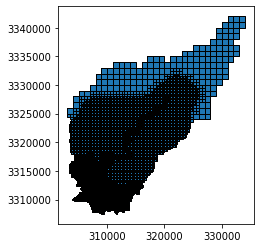

In [12]:
# Plot Model Grid GeoDataFrame
Grid_GDF.plot(edgecolor = 'k')

In [13]:
# Show contents of GeoDataFrame
Grid_GDF.head()

,Area_m2,CellID,iuzno,L1_idomain,L2_idomain,L3_idomain,L4_idomain,L5_idomain,L6_idomain,L7_idomain,geometry
0,1000000.0,1,-1,1,1,1,1,1,1,1,"POLYGON ((331000 3342000, 332000 3342000, 3320..."
1,1000000.0,2,-1,1,1,1,1,1,1,1,"POLYGON ((332000 3342000, 333000 3342000, 3330..."
2,1000000.0,3,-1,1,1,1,1,1,1,1,"POLYGON ((333000 3342000, 334000 3342000, 3340..."
3,1000000.0,4,-1,1,1,1,1,1,1,1,"POLYGON ((330000 3341000, 331000 3341000, 3310..."
4,1000000.0,5,1,1,1,1,1,1,1,1,"POLYGON ((331000 3341000, 332000 3341000, 3320..."


In [14]:
# Load georeferenced shapefile in order to assign projection to newly-created shapefile
SiteWS = gpd.read_file( WS_shp )
# Get CRS object from shapefile
ProjCRS = SiteWS.crs
# Set CRS of MODFLOW Grid GeoDataFrame
Grid_GDF.crs = ProjCRS 

In [15]:
# Get Top Active layer as a column and remove idomain columns
# Define function
def TopAct(row):
    CL = np.array(row.index)
    inds = [True if 'idomain' in x else False for x in CL]
    try:
        y = int(np.where(row.values[inds] == 1)[0].min()+1)
    except:
        y = -1
    return y
Grid_GDF['TopActive'] = Grid_GDF.apply(lambda x: int(TopAct(x)), axis = 1)

In [16]:
Grid_GDF['TopActive']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       2
17       2
18       1
19       1
20       1
21       1
22       2
23       2
24       1
25       1
26       1
27       1
28       1
29       2
        ..
12317    4
12318    4
12319    4
12320    4
12321    4
12322    4
12323    4
12324    4
12325    4
12326    4
12327    4
12328    3
12329    3
12330    4
12331    3
12332    4
12333    3
12334    3
12335    3
12336    3
12337    3
12338    3
12339   -1
12340    3
12341    3
12342    3
12343    3
12344   -1
12345    3
12346    3
Name: TopActive, Length: 12347, dtype: int64

In [17]:
# Subset to only columns necessary for creating pickle files
Grid_GDF = Grid_GDF[['CellID','TopActive','iuzno','Area_m2','geometry']]

In [18]:
Grid_GDF

,CellID,TopActive,iuzno,Area_m2,geometry
0,1,1,-1,1000000.0,"POLYGON ((331000 3342000, 332000 3342000, 3320..."
1,2,1,-1,1000000.0,"POLYGON ((332000 3342000, 333000 3342000, 3330..."
2,3,1,-1,1000000.0,"POLYGON ((333000 3342000, 334000 3342000, 3340..."
3,4,1,-1,1000000.0,"POLYGON ((330000 3341000, 331000 3341000, 3310..."
4,5,1,1,1000000.0,"POLYGON ((331000 3341000, 332000 3341000, 3320..."
5,6,1,2,1000000.0,"POLYGON ((332000 3341000, 333000 3341000, 3330..."
6,7,1,-1,1000000.0,"POLYGON ((333000 3341000, 334000 3341000, 3340..."
7,8,1,-1,1000000.0,"POLYGON ((329000 3340000, 330000 3340000, 3300..."
8,9,1,3,1000000.0,"POLYGON ((330000 3340000, 331000 3340000, 3310..."
9,10,1,4,1000000.0,"POLYGON ((331000 3340000, 332000 3340000, 3320..."


In [19]:
# Write out to shapefile
ModGrid_PATH = os.path.join(ROOT,r'gis_files/Ex_ModGrid.shp')
Grid_GDF.to_file(ModGrid_PATH)

At this point, if you wish to take advantage of the ability to add weights to the mapping, you can bring this shapefile into some GIS software and intersect it with your mapping shapefiles.  In our case, we intersected the Modflow Grid with polygons of the SSURGO Hydrologic Soil Classification (to weight cells with high infiltration rates higher) and the surface extent of the impermeable Ft. Terrett formation (to weight impermeable surfaces lower).

## Load Shapefiles and Check CRS

Load shapefile of designated HSPF subbasins, HSPF stream reaches and MODFLOW Grid.  Verify that they share the same CRS so that we can perform intersection operations.

In [20]:
Reaches = gpd.read_file( Reach_shp )
Subbasins = gpd.read_file( Sub_shp )
SiteWS = gpd.read_file( WS_shp )
MGrid = gpd.read_file( MGrid_shp )

In [21]:
SiteWS.crs

{'init': 'epsg:32614'}

In [22]:
Reaches.crs

{'init': 'epsg:32614'}

In [23]:
Subbasins.crs

{'init': 'epsg:32614'}

In [24]:
MGrid

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,geometry
0,1,1,-1,D,0,1,"POLYGON ((331000 3342000, 332000 3342000, 3320..."
1,2,1,-1,D,0,1,"POLYGON ((332000 3342000, 333000 3342000, 3330..."
2,3,1,-1,D,0,1,"POLYGON ((333000 3342000, 334000 3342000, 3340..."
3,4,1,-1,D,0,1,"POLYGON ((330000 3341000, 331000 3341000, 3310..."
4,5,1,1,D,0,1,"POLYGON ((331000 3341000, 332000 3341000, 3320..."
5,6,1,2,D,0,1,"POLYGON ((332000 3341000, 333000 3341000, 3330..."
6,7,1,-1,D,0,1,"POLYGON ((333000 3341000, 334000 3341000, 3340..."
7,8,1,-1,D,0,1,"POLYGON ((329000 3340000, 330000 3340000, 3300..."
8,9,1,3,D,0,1,"POLYGON ((330000 3340000, 331000 3340000, 3310..."
9,10,1,4,D,0,1,"POLYGON ((331000 3340000, 332000 3340000, 3320..."


#### Plot Top Active Layer

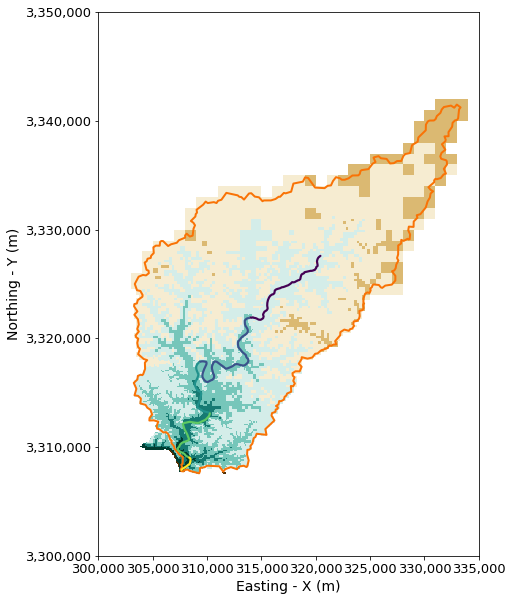

In [25]:
# Plot to make sure they align - Model Grid Cells
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 10.0)
ax11 = Fig1.add_subplot(111)
# Color according to IDOMAIN value of Layer 1
MGrid.plot( column="TopAct", cmap="BrBG", ax=ax11 )
SiteWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
Reaches.plot( ax=ax11, column = 'Id', linewidth=2 )
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

#### Plot PERLND Structures

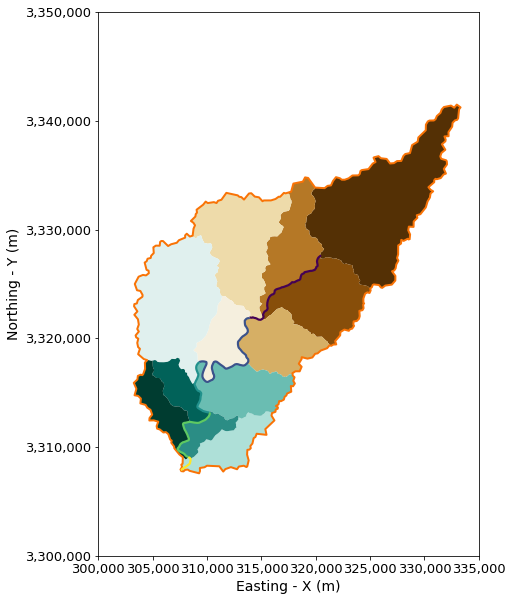

In [26]:
# Plot to make sure they align - Model Grid Cells
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 10.0)
ax11 = Fig1.add_subplot(111)
# Color according to IDOMAIN value of Layer 1
Subbasins.plot( column="Id", cmap="BrBG", ax=ax11 )
SiteWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
Reaches.plot( ax=ax11, column = 'Id', linewidth=2 )
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

## Make Input Dictionary to map RCHRES structures onto MODFLOW cells

In this section, we use a shapefile of river reaches as buffered polygons created from line segements with fields "TargId", "GWExit", "LName", and "RLength" to create our mapping dictionary.  **A user would only need to include ID, TargID and GWExit if they were using their own shapefile.**

In [27]:
Reaches.head()

,Id,TargId,GWExit,LName,RLength,geometry
0,1,R001,2,Upper Dolan Creek,10242.027966,"POLYGON ((313967.709323816 3321800.35389233, 3..."
1,2,R002,2,Upper Central,13804.821259,"POLYGON ((309347.4998185346 3317732.820966259,..."
2,3,R003,2,Lower Central,5878.525280,"POLYGON ((310261.8077358697 3313233.162526099,..."
3,4,R004,2,Lower,7254.425563,"POLYGON ((308335.3387371721 3309163.57854354, ..."
4,5,R005,0,Dolan Springs,1745.430893,"POLYGON ((307654.9169038786 3307786.779993379,..."


In [28]:
# Calculate Area of each buffered reach
Reaches['Area_m2'] = Reaches['geometry'].area

In [29]:
# Intersect buffered reaches GeoDataFrame with MODFLOW grid cells
AllGridRchs = gpd.overlay( Reaches, MGrid, how='intersection' )

In [30]:
# Determine whether any Modflow grid cells are connected to 2+ RCHRES structures
print('Connections:',len(AllGridRchs['CellID']))
print('Unique MODFLOW Cells:',len(np.unique(AllGridRchs['CellID'])))

Connections: 1353
Unique MODFLOW Cells: 1337


It looks like there are some instances of grid cells having multiple connections that we will need to take care of.

In [31]:
# Use a Groupby + first selection to ensure that no Modflow Cell is connected to 2+ reach reservoirs
AllGridRchs = AllGridRchs.groupby('CellID').first()

In [32]:
# Make sure that the last function worked
print('Connections:',len(AllGridRchs.index))
print('Unique MODFLOW Cells:',len(np.unique(AllGridRchs.index)))

Connections: 1337
Unique MODFLOW Cells: 1337


Using the groupby function converted this from a GeoDataFrame into a DataFrame, so we will need to convert it back

In [33]:
# Turn back into GeoDataFrame after Groupby operation
GridRchs = gpd.GeoDataFrame(AllGridRchs,geometry = 'geometry', crs = ProjCRS)

In [34]:
# Calculate area for Reach-MODFLOW Cell intersections
GridRchs["SArea_m2"] = GridRchs["geometry"].area

Add a column of Weights based on the values in the HSoil and FtTerrOut columns.

In [35]:
# Create Weighting Dictionary
HSMapDict = { 'A' : 100.0,
              'B' : 10.0,
              'C' : 1.0,
              'D' : 0.1, }
# Define weighting function
def setWeights( HSoil, mapDict ):
    """Custom function to set the weight based on hydrologic soil type
    
    Args:
        HSoil (str): hydrologic soil type. One of 'A', 'B', 'C', 'D'
    """
    if HSoil in mapDict.keys():
        cWeight = mapDict[HSoil]
    else:
        cWeight = 0.0
    # end if
    return cWeight

In [36]:
GridRchs['Weight'] = GridRchs.apply( lambda row: setWeights( row['HSoil'], HSMapDict ), 
                                             axis=1 )

In [37]:
GridRchs['Weight'] = np.where( GridRchs["FtTerrOut"] == 1, 0.0, GridRchs['Weight'] )

In [38]:
# Create New Headers for Mapping Dataframe
NewHdrs = [ "CellID", #0 1-based cell ID
            "iuzno", #1 1-based UZF cell ID
            "TopActive", #2 1-based top active layer
            "SArea_m2", #3 Area of Intersection, m2
            "Weight", #4 Weighting Value
          ]

In [39]:
GridRchs

,Id,TargId,GWExit,LName,RLength,Area_m2,TopAct,iuzno,HSoil,FtTerrOut,HRU,geometry,SArea_m2,Weight
CellID,,,,,,,,,,,,,,
850,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,810,A,0,3,"POLYGON ((320172.6206015865 3327500, 320206.49...",3062.448378,100.0
851,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,811,A,0,3,"POLYGON ((320314.3789288013 3327625, 320358.62...",1500.791397,100.0
852,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,812,A,0,1,"POLYGON ((320375 3327672.505813834, 320383.748...",6354.760087,100.0
853,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,813,A,0,3,"POLYGON ((320250 3327571.862347267, 320314.378...",13914.527419,100.0
854,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,814,A,0,2,"POLYGON ((320500 3327521.503673377, 320499.755...",15395.892425,100.0
860,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,820,A,0,1,"POLYGON ((320500 3327647.243914574, 320505.266...",165.182811,100.0
862,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,822,A,0,1,"POLYGON ((320513.5660349586 3327625, 320514.55...",1738.703523,100.0
865,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,825,A,0,3,"POLYGON ((320095.4242109009 3327375, 320113.85...",905.226582,100.0
866,1,R001,2,Upper Dolan Creek,10242.027966,2.062256e+06,3,826,A,0,3,"POLYGON ((320125 3327432.671759466, 320160.145...",14080.387807,100.0


This contains everything we need in our mapping dictionary, so we will create the dictionary and save it out to a pickle

In [40]:
# Create Dictionary to store Mapping Dataframes, cell areas, and number of exits for each reach
WS_RCHRES = dict()
# Iterate to create dataframes for each subbasin
for i,ID in enumerate(Reaches['Id']):
    print('Creating Mapping for Target',Reaches['TargId'][i])
    # Copy portion of DataFrame with correct Subbasin ID
    RchGrid = GridRchs[GridRchs["Id"] == ID].copy()
    # Set MODFLOW Cell ID as index
    dfIndexer = np.array( RchGrid.index.tolist(), dtype=np.int32 )
    # Create DataDict of area of each intersected MODFLOW grid cell
    DataDict = { NewHdrs[1] : np.array( RchGrid["iuzno"].tolist(), dtype=int ),
                 NewHdrs[2] : np.array( RchGrid["TopAct"].tolist(), dtype=int ),
                 NewHdrs[3] : np.array( RchGrid["SArea_m2"].tolist(), dtype=np.float64 ),
                NewHdrs[4] : np.array( RchGrid["Weight"].tolist(), dtype=np.float64 ),
                
                 }
    # Create DataFrame and add to dictionary
    DF = pd.DataFrame( index=dfIndexer, data=DataDict )
    # Calculate 
    CalcRArea = DF[NewHdrs[3]].sum()
    WS_RCHRES[ID] = [Reaches['GWExit'][i],CalcRArea,DF]

Creating Mapping for Target R001
Creating Mapping for Target R002
Creating Mapping for Target R003
Creating Mapping for Target R004
Creating Mapping for Target R005


In [41]:
# Pickle Dictionary
OutFile = "WS_Rchres.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( WS_RCHRES, OP, pickle.HIGHEST_PROTOCOL )

## Make Input Dictionary to Map PERLND Structures onto MODFLOW Cells

Intersect MODFLOW Grid GeoDataFrame with HSPF Shapefiles to create dataframe for each subbasin with two columns: MODFLOW 1-based Cell ID and area of that cell within the subbasin.

In [42]:
Subbasins['Area_m2'] = Subbasins['geometry'].area

In [43]:
# Intersect Grid GeoDataFrame with Subbasins GeoDataFrame
AllGridSubs = gpd.overlay( Subbasins, MGrid, how='intersection' )

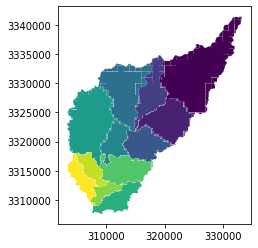

In [44]:
# Plot to verify that intersection worked
AllGridSubs.plot( column='Id', edgecolor = None )

To ensure we have a valid 1:1 mapping of MODFLOW cells to HSPF structures, we want to first remove any entries from this dataframe for which we already have a mapping to a RCHRES structure.

In [45]:
print(len(AllGridSubs),'Connections')

12872 Connections


In [46]:
# Identify list of RCHRES-mapped CellID's
RRIDs = GridRchs.index
# Subset to cells with CellID not in this list
AllGridSubs = AllGridSubs[AllGridSubs['CellID'].apply(lambda x: not x in RRIDs)]

In [47]:
print(len(AllGridSubs),'Connections')

11036 Connections


Now we need to ensure that there are not any MODFLOW cells that are mapped to multiple PERLND structures

In [48]:
# Determine whether any Modflow grid cells are connected to 2+ PERLND structures
print('Connections:',len(AllGridSubs['CellID']))
print('Unique MODFLOW Cells:',len(np.unique(AllGridSubs['CellID'])))

Connections: 11036
Unique MODFLOW Cells: 10463


In [49]:
# Use a Groupby + first selection to ensure that no Modflow Cell is connected to 2+ reach reservoirs
AllGridSubs = AllGridSubs.groupby('CellID').first()

In [50]:
# Make sure that the last function worked
print('Connections:',len(AllGridSubs.index))
print('Unique MODFLOW Cells:',len(np.unique(AllGridSubs.index)))

Connections: 10463
Unique MODFLOW Cells: 10463


Using the groupby function converted this from a GeoDataFrame into a DataFrame, so we will need to convert it back

In [51]:
# Turn back into GeoDataFrame after Groupby operation
GridSubs = gpd.GeoDataFrame(AllGridSubs,geometry = 'geometry', crs = ProjCRS)

In [52]:
# Calculate area for PERLND-MODFLOW Cell intersections
GridSubs["NewArea_m2"] = GridSubs["geometry"].area

Add a column of Weights based on the values in the HSoil and FtTerrOut columns.

In [53]:
GridSubs['Weight'] = GridSubs.apply( lambda row: setWeights( row['HSoil'], HSMapDict ), 
                                             axis=1 )

In [54]:
GridSubs['Weight'] = np.where( GridSubs["FtTerrOut"] == 1, 0.0, GridSubs['Weight'] )

In [55]:
SIdList = np.unique(GridSubs['Id'])

In [56]:
# Create list of structure names for keys for input maping dictionary
PTargIdList = [ "P{:03d}".format( x ) for x in SIdList ]
PTargIdList

['P001',
 'P002',
 'P003',
 'P004',
 'P005',
 'P006',
 'P007',
 'P008',
 'P009',
 'P010',
 'P011',
 'P012']

In [57]:
# Create New Headers for Mapping Dataframe
NewHdrs = [ "CellID", #0 1-based cell ID
            "iuzno", #1 1-based UZF cell ID
            "TopActive", #2 1-based top active layer
            "SArea_m2", #3 Area of intersection, m2
            "Weight", #4 Weighting for area
          ]

In [58]:
GridSubs

,Id,Name,Desc_,POLY_AREA,CENTROID_X,CENTROID_Y,PERIMETER,Area_m2,TopAct,iuzno,HSoil,FtTerrOut,HRU,geometry,NewArea_m2,Weight
CellID,,,,,,,,,,,,,,,,
1,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((331566.5417048538 3341000, 331586.39...",97579.227487,0.1
2,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((332000 3341321.152269173, 332437.947...",351405.846060,0.1
3,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((333000 3341479.818182086, 333318.109...",93969.968669,0.1
4,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((330394.8059037241 3340000, 330459.04...",28922.385971,0.1
5,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,1,D,0,1,"POLYGON ((331000 3340147.5138482, 331017.97749...",754758.072317,0.1
6,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,2,D,0,1,"POLYGON ((333000 3340097.462996046, 332999.722...",984574.121528,0.1
7,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((333174.4398181493 3341000, 333095.54...",109152.918340,0.1
8,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,-1,D,0,1,"POLYGON ((329974.5073994907 3339000, 330000 33...",314.561497,0.1
9,1,Upper Dolan Creek,Upper Dolan Creek,1.025372e+08,325901.162728,3.332178e+06,58189.010423,1.025372e+08,1,3,D,0,1,"POLYGON ((330000 3339024.67865114, 330117.0779...",848079.236368,0.1


In [59]:
# Create Dictionary to store Mapping Dataframes and cell areas.
WS_PERLND = dict()
# Iterate to create dataframes for each subbasin
for i in SIdList:
    print('Creating Mapping for Target',PTargIdList[i-1])
    # Copy portion of DataFrame with correct Subbasin ID
    SubGrid = GridSubs[GridSubs["Id"] == i].copy()
    # Set MODFLOW Cell ID as index
    dfIndexer = np.array( SubGrid.index.tolist(), dtype=np.int32 )
    # Create DataDict of area of each intersected MODFLOW grid cell
    DataDict = { NewHdrs[1] : np.array( SubGrid["iuzno"].tolist(), dtype=int ),
                 NewHdrs[2] : np.array( SubGrid["TopAct"].tolist(), dtype=np.int ),
                 NewHdrs[3] : np.array( SubGrid["NewArea_m2"].tolist(), dtype=np.float64 ),
                 NewHdrs[4] : np.array( SubGrid["Weight"].tolist(), dtype=np.float64 ), 
             }
    # Create DataFrame and add to dictionary
    DF = pd.DataFrame( index=dfIndexer, data=DataDict )
    CalcSArea = DF[NewHdrs[3]].sum()
    WS_PERLND[PTargIdList[i-1]] = [CalcSArea,DF]

Creating Mapping for Target P001
Creating Mapping for Target P002
Creating Mapping for Target P003
Creating Mapping for Target P004
Creating Mapping for Target P005
Creating Mapping for Target P006
Creating Mapping for Target P007
Creating Mapping for Target P008
Creating Mapping for Target P009
Creating Mapping for Target P010
Creating Mapping for Target P011
Creating Mapping for Target P012


In [60]:
# Pickle Dictionary
OutFile = "WS_Perlnd.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( WS_PERLND, OP, pickle.HIGHEST_PROTOCOL )

## Make Input Dictionary to Map PERLND and RCHRES Structures onto MODFLOW Cells with Springs

In this part of the workbook, we map MODFLOW drain cells to corresponding HSPF structure.  We use flopy to directly interrogate the drain package and determine where springs are located in the MODFLOW model.

**Note that the required Spring dictionary format is different from what is used in this notebook as of 2023-01-01**

In [61]:
# Identify locations / Cell ID's of MODFLOW DRN cells
# Get data from Drain Package
drn = mf6.get_package( 'drn' )
drn_data = drn.stress_period_data.get_data()
# Create list of 1-based 2D Cell ID's for springs
Spr_List = [x[1]+1 for x in drn_data[0]['cellid']]
# Create list of spring names
SprName_List = [x for x in drn_data[0]['boundname']]

In [62]:
print(SprName_List)

['finegan', 'ud704', 'ud703', 'dolan', 'ud701']


In [63]:
# Create subset of Grid_GDF for matching 1-based MODFLOW Cell ID
Spr_GDF = MGrid[MGrid['CellID'].apply(lambda x: x in Spr_List)]
# Add name of each spring to use as key in the DataFrame
Spr_GDF['SprName'] = Spr_GDF['CellID'].apply(lambda x: SprName_List[np.where(np.asarray(Spr_List) == x)[0][0]])
# Calculate area of each spring cell
Spr_GDF['GridArea_m2'] = Spr_GDF['geometry'].area

C:\Users\psouthard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\psouthard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
# Intersect new DataFrame with Buffered Reaches and PERVLND structures
# Intersect Grid GeoDataFrame with Subbasins GeoDataFrame
AllSprSubs = gpd.overlay( Subbasins, Spr_GDF, how='intersection' )
# Intersect Grid GeoDataFrame with Buffered Reaches GeoDataFrame
AllSprRchs = gpd.overlay( Reaches, Spr_GDF, how='intersection' )

In [65]:
AllSprSubs

,Id,Name,Desc_,POLY_AREA,CENTROID_X,CENTROID_Y,PERIMETER,Area_m2,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,SprName,GridArea_m2,geometry
3,8,Dolan Springs,Rough Spring Canyon,2.151592e+07,312082.611044,3.310182e+06,27217.101091,2.151592e+07,11799,5,-1,D,0,8,ud701,3906.25,"POLYGON ((308937.5 3308937.5, 309000 3308937.5..."
5,10,Escondido Canyon,Escondido Canyon,1.010613e+07,309794.860241,3.311356e+06,18015.324176,1.010613e+07,11185,5,-1,D,0,10,dolan,3906.25,"POLYGON ((308625 3309125, 308687.5 3309125, 30..."


In [66]:
# Create Dictionary with Mapping info
WS_SPRINGS = dict()
# Iterate through RCHRES structures first
for i in Spr_GDF['SprName'].tolist():
    print('Creating Mapping for Target',i)
    cId = Spr_GDF[Spr_GDF['SprName'] == i]['CellID'].tolist()[0]
    if len(AllSprRchs[AllSprRchs['CellID'] == cId]) > 0:
        # HSPF Target ID
        cTarg = AllSprRchs[AllSprRchs['CellID'] == cId]['TargId'].tolist()[0]
        # Top Active Layer
        cTopAct = AllSprRchs[AllSprRchs['CellID'] == cId]['TopAct'].tolist()[0]
        # Cell Area
        cArea = AllSprRchs[AllSprRchs['CellID'] == cId]['GridArea_m2'].tolist()[0]
        WS_SPRINGS[i] = [cTarg,cId,cTopAct,cArea]
    elif len(AllSprSubs[AllSprSubs['CellID'] == cId]) > 0:
        # HSPF Target ID
        cTargID = AllSprSubs[AllSprSubs['CellID'] == cId]['Id'].tolist()[0]
        cTarg = PTargIdList[cTargID-1]
        # Top Active Layer
        cTopAct = AllSprSubs[AllSprSubs['CellID'] == cId]['TopAct'].tolist()[0]
        # Cell Area
        cArea = AllSprSubs[AllSprSubs['CellID'] == cId]['GridArea_m2'].tolist()[0]
        WS_SPRINGS[i] = [cTarg,cId,cTopAct,cArea]
    else:
        # Cell Area
        cArea = Spr_GDF[Spr_GDF['CellID'] == cId]['GridArea_m2'].tolist()[0]
        # Top Active Layer
        cTopAct = Spr_GDF[Spr_GDF['CellID'] == cId]['TopAct'].tolist()[0]
        WS_SPRINGS[i] = ['Outside',cId,cTopAct,cArea]

Creating Mapping for Target finegan
Creating Mapping for Target dolan
Creating Mapping for Target ud704
Creating Mapping for Target ud703
Creating Mapping for Target ud701


In [67]:
WS_SPRINGS

{'finegan': ['Outside', 9725, 5, 15625.0],
 'dolan': ['P010', 11185, 5, 3906.25],
 'ud704': ['Outside', 11566, 5, 3906.25],
 'ud703': ['Outside', 11603, 5, 3906.25],
 'ud701': ['P008', 11799, 5, 3906.25]}

In [68]:
# Pickle Dictionary
OutFile = "WS_Springs.pickle"
OutFP = os.path.normpath( os.path.join( OUT_DIR, OutFile ) )
with open( OutFP, 'wb' ) as OP:
    pickle.dump( WS_SPRINGS, OP, pickle.HIGHEST_PROTOCOL )